<a href="https://colab.research.google.com/github/mateuszklinowski/commaai/blob/master/Commaai_with_absdiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print(tf.version.VERSION)

2.0.0


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt

Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
predictor = open('/content/drive/My Drive/speedchallenge/train.txt', 'r').readlines()
predictor = list(map(lambda x: float(x), predictor))
values_ds = tf.data.Dataset.from_tensor_slices(tf.cast(predictor, tf.double))

for label in values_ds.take(10):
  print(label)

tf.Tensor(28.10556983947754, shape=(), dtype=float64)
tf.Tensor(28.10556983947754, shape=(), dtype=float64)
tf.Tensor(28.10652732849121, shape=(), dtype=float64)
tf.Tensor(28.130403518676758, shape=(), dtype=float64)
tf.Tensor(28.109243392944336, shape=(), dtype=float64)
tf.Tensor(28.088571548461914, shape=(), dtype=float64)
tf.Tensor(28.034210205078125, shape=(), dtype=float64)
tf.Tensor(28.018491744995117, shape=(), dtype=float64)
tf.Tensor(27.986623764038086, shape=(), dtype=float64)
tf.Tensor(28.0163516998291, shape=(), dtype=float64)


In [0]:
images_dir = r'./drive/My Drive/speedchallenge/absdiff_frames'
print("Number of training frames: ", len(os.listdir(images_dir)))

Number of training frames:  20400


In [0]:
BATCH_SIZE = 100
IMG_WIDTH = 320
IMG_HEIGTH = 240
IMG_SHAPE = (IMG_HEIGTH, IMG_WIDTH)

Creating images generator

FOR NOT IMAGE GENERATOR IS NOT USED,
IDK how to connect it with labels


In [0]:
import pathlib
import re

data_root = pathlib.Path(images_dir)

def sortSecond(val): 
    return val[1] 
    
all_image_paths = list()
for item in data_root.iterdir():
    all_image_paths.append(item)

all_image_paths = [str(path) for path in all_image_paths]
sorted_image_paths = list(map(lambda path: (path, int(re.sub("[^0-9]", "", path))), all_image_paths))
#path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
sorted_image_paths.sort(key=sortSecond)
sorted_image_paths = list(map(lambda pathTuple: pathTuple[0] , sorted_image_paths))
sorted_image_paths[:11]

['drive/My Drive/speedchallenge/absdiff_frames/frame_0.png',
 'drive/My Drive/speedchallenge/absdiff_frames/frame_1.png',
 'drive/My Drive/speedchallenge/absdiff_frames/frame_2.png',
 'drive/My Drive/speedchallenge/absdiff_frames/frame_3.png',
 'drive/My Drive/speedchallenge/absdiff_frames/frame_4.png',
 'drive/My Drive/speedchallenge/absdiff_frames/frame_5.png',
 'drive/My Drive/speedchallenge/absdiff_frames/frame_6.png',
 'drive/My Drive/speedchallenge/absdiff_frames/frame_7.png',
 'drive/My Drive/speedchallenge/absdiff_frames/frame_8.png',
 'drive/My Drive/speedchallenge/absdiff_frames/frame_9.png',
 'drive/My Drive/speedchallenge/absdiff_frames/frame_10.png']

In [0]:
def preprocess_image(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGTH, IMG_WIDTH])
    image /= 255.0
    return image

def load_and_process_image(image_path):
    image = tf.io.read_file(image_path)
    return preprocess_image(image)

path_ds = tf.data.Dataset.from_tensor_slices(sorted_image_paths)
image_ds = path_ds.map(load_and_process_image)
image_ds

<MapDataset shapes: (240, 320, 3), types: tf.float32>

Creating ZIP form labels and images

In [0]:
image_label_ds = tf.data.Dataset.zip((image_ds, values_ds))
print("DataSet: ", image_label_ds)

DataSet:  <ZipDataset shapes: ((240, 320, 3), ()), types: (tf.float32, tf.float64)>


Define model

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGTH, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 318, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 159, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 157, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 78, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 76, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 38, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 36, 128)       1

In [0]:
image_label_ds = image_label_ds.shuffle(3670)

train_ds = image_label_ds.take(int(0.8*20400))
temp_ds = image_label_ds.skip(int(0.8*20400))

cross_validation_ds = temp_ds.take(int(0.8*20400*0.05))
test_ds = temp_ds.skip(int(0.8*20400*0.05))

train_batches = train_ds.shuffle(3670).batch(BATCH_SIZE).prefetch(1)
test_batches = test_ds.shuffle(3670).batch(BATCH_SIZE).prefetch(1)
cross_validation_ds = cross_validation_ds.shuffle(3670).batch(BATCH_SIZE).prefetch(1)

In [0]:
epochs=10
history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=test_batches,
    verbose=2,
)

Epoch 1/10
164/164 - 5537s - loss: 28.5560 - mean_squared_error: 28.6491 - val_loss: 0.0000e+00 - val_mean_squared_error: 0.0000e+00
Epoch 2/10
164/164 - 188s - loss: 10.9353 - mean_squared_error: 10.9258 - val_loss: 3.4849 - val_mean_squared_error: 3.4853
Epoch 3/10
164/164 - 184s - loss: 7.0749 - mean_squared_error: 7.0733 - val_loss: 3.0806 - val_mean_squared_error: 3.0825
Epoch 4/10
164/164 - 185s - loss: 5.1170 - mean_squared_error: 5.1191 - val_loss: 2.3860 - val_mean_squared_error: 2.3877
Epoch 5/10
164/164 - 186s - loss: 3.8370 - mean_squared_error: 3.8339 - val_loss: 1.5933 - val_mean_squared_error: 1.5958
Epoch 6/10
164/164 - 188s - loss: 3.2491 - mean_squared_error: 3.2467 - val_loss: 4.7974 - val_mean_squared_error: 4.7839
Epoch 7/10
164/164 - 184s - loss: 2.7193 - mean_squared_error: 2.7190 - val_loss: 1.0824 - val_mean_squared_error: 1.0843
Epoch 8/10
164/164 - 182s - loss: 2.2199 - mean_squared_error: 2.2180 - val_loss: 0.9018 - val_mean_squared_error: 0.9036
Epoch 9/10


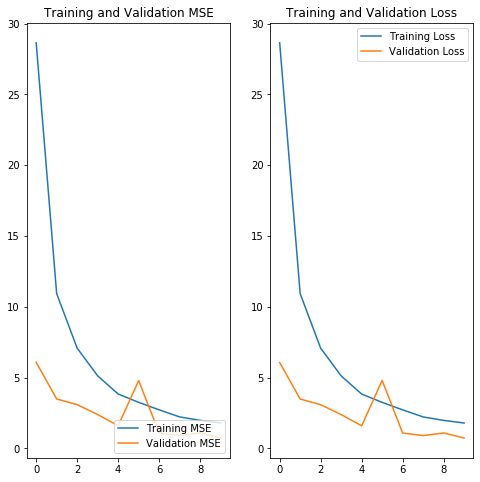

In [0]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mse, label='Training MSE')
plt.plot(epochs_range, val_mse, label='Validation MSE')
plt.legend(loc='lower right')
plt.title('Training and Validation MSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
print(2)

2


In [0]:
test_ds = tf.data.Dataset.zip((image_ds, values_ds))

In [0]:
image_batch, label_batch = next(iter(image_label_ds.take(10)))
#image_batch = image_batch.numpy()
#result_batch = model.predict(image_batch)

In [0]:
test = image_batch.reshape(1, 240, 320, 3)
result_batch = model.predict(test)

In [0]:
print(result_batch)
print(label_batch)

[[26.543022]]
tf.Tensor(28.10556983947754, shape=(), dtype=float64)


#Saving model


In [0]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [0]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
speedchallenge_path = r'./drive/My Drive/speedchallenge/commaai_model_absdiff.h5';
model.save(speedchallenge_path) 